### Import libraries

In [67]:
import numpy as np
import logging
import random

In [68]:

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [70]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

## Dataset

### Load the data

In [6]:
dataset_dir = 'dataset'
dataset = np.load(f'{dataset_dir}/public_data.npz', allow_pickle=True)
X = dataset['data']
y = dataset['labels']
labels = {0:'healthy', 1:'unhealthy'}

print(f'Dataset Data Shape {X.shape}, type = {X[0].dtype}')
print(f'Dataset Labels Shape {y.shape}')


Dataset Data Shape (5200, 96, 96, 3), type = float32
Dataset Labels Shape (5200,)


## Inspect the data

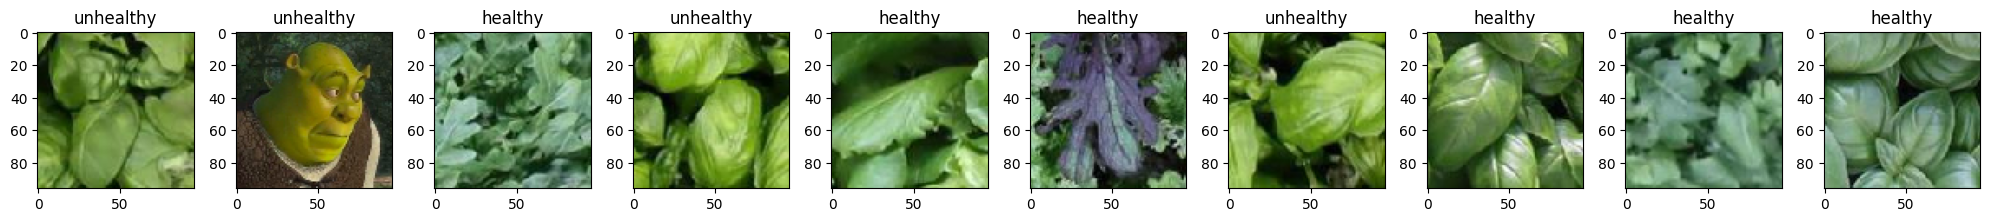

In [7]:
# Display a sample of images from the training-validation dataset
num_img = 10
to_show = np.random.randint(0, X.shape[0], num_img);
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i]
    ax.imshow(X[to_show[i]]/255)
    ax.set_title('{}'.format(y[to_show[i]]))

# Adjust layout and display the images
plt.tight_layout()
plt.show()


In [8]:
# Display the count of occurrences of target classes in the training-validation dataset    
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['class'])['class'].value_counts())

Counting occurrences of target classes:
healthy      3199
unhealthy    2001
Name: class, dtype: int64


### Inspection consideration
1. Labels are not balanced
2. Outliers on the dataset are present
3. Labels are not correctly formatted 'healthy' -> 0, 'unhealthy' -> 1
4. Dataset is not normalized

## Preprocessing

### Labels encoding

In [9]:
def custom_label_encoder(data, encoding_preferences):
    encoded_data = np.array([encoding_preferences.get(val, -1) for val in data])
    return encoded_data

encoding = {
    'healthy': 0,
    'unhealthy': 1,
}
y = custom_label_encoder(y, encoding)

print(f'Dataset Labels Shape {y.shape}')
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['class'])['class'].value_counts())


Dataset Labels Shape (5200,)
Counting occurrences of target classes:
0    3199
1    2001
Name: class, dtype: int64


### Dataset normalized

In [10]:
X = (X / 255).astype('float32')
print(f'Dataset Data Shape {X.shape}')


Dataset Data Shape (5200, 96, 96, 3)


### Outliers

In [12]:
outliers_idxs = np.load('outliers_idxs.npy')
mask = np.ones(len(X), dtype=bool)
mask[outliers_idxs] = False

X = X[mask]
y = y[mask]

### Not balanced

In [71]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y,
    test_size=0.1,
    stratify=y,
    random_state=seed
)
# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    stratify=y_train_val,
    random_state=seed
)

# Print the shapes of the resulting datasets
print("Training_Validation Data Shape:", X_train_val.shape)
print("Training_Validation Label Shape:", y_train_val.shape)
print("Train Data Shape:", X_train.shape)
print("Train Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training_Validation Data Shape: (4503, 96, 96, 3)
Training_Validation Label Shape: (4503,)
Train Data Shape: (4002, 96, 96, 3)
Train Label Shape: (4002,)
Validation Data Shape: (501, 96, 96, 3)
Validation Label Shape: (501,)
Test Data Shape: (501, 96, 96, 3)
Test Label Shape: (501,)


In [15]:

# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of y_train classes:')
print(pd.DataFrame(y_train, columns=['class'])['class'].value_counts())

print('Counting occurrences of y_val classes:')
print(pd.DataFrame(y_val, columns=['class'])['class'].value_counts())

print('Counting occurrences of y_test classes:')
print(pd.DataFrame(y_test, columns=['class'])['class'].value_counts())

Counting occurrences of y_train classes:
0    2480
1    1522
Name: class, dtype: int64
Counting occurrences of y_val classes:
0    311
1    190
Name: class, dtype: int64
Counting occurrences of y_test classes:
0    310
1    191
Name: class, dtype: int64


## Build quasiVGG9 model

In [33]:
def build_quasiVGG9(input_shape, output_shape):
    model = tfk.Sequential(name='quasiVGG9')

    model.add(tfkl.Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape, name='conv00'))
    model.add(tfkl.Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv01'))
    model.add(tfkl.MaxPooling2D(name='mp0'))

    model.add(tfkl.Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv10'))
    model.add(tfkl.Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv11'))
    model.add(tfkl.MaxPooling2D(name='mp1'))

    model.add(tfkl.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='conv20'))
    model.add(tfkl.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='conv21'))
    model.add(tfkl.MaxPooling2D(name='mp2'))

    model.add(tfkl.Conv2D(256, kernel_size=3, padding='same', activation='relu', name='conv30'))
    model.add(tfkl.Conv2D(256, kernel_size=3, padding='same', activation='relu', name='conv31'))
    model.add(tfkl.GlobalAveragePooling2D(name='gap'))

    model.add(tfkl.Dense(output_shape, activation='sigmoid', name='Output'))  # Use 'sigmoid' for binary classification
    
    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(5e-4), metrics=['accuracy'])
    
    return model

In [34]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = 1  # Output shape for the model
batch_size = 128                # Batch size for training
epochs = 200                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 128
Input Shape: (96, 96, 3)
Output Shape: 1


In [35]:
# Build the LeNet model and display its summary
model = build_quasiVGG9(input_shape, output_shape)
model.summary()

Model: "quasiVGG9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv00 (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv01 (Conv2D)             (None, 96, 96, 32)        9248      
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv10 (Conv2D)             (None, 48, 48, 64)        18496     
                                                                 
 conv11 (Conv2D)             (None, 48, 48, 64)        36928     
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0         
                                                                 
 conv20 (Conv2D)             (None, 24, 24, 128)       73

### Train the model

In [36]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

model.save('QuasiVGG9')

Epoch 1/200
32/32 [==============================] - 53s 2s/step - loss: 0.6702 - accuracy: 0.6197 - val_loss: 0.6593 - val_accuracy: 0.6208
Epoch 2/200
32/32 [==============================] - 51s 2s/step - loss: 0.6615 - accuracy: 0.6197 - val_loss: 0.6561 - val_accuracy: 0.6208
Epoch 3/200
32/32 [==============================] - 51s 2s/step - loss: 0.6638 - accuracy: 0.6292 - val_loss: 0.6630 - val_accuracy: 0.6208
Epoch 4/200
32/32 [==============================] - 55s 2s/step - loss: 0.6475 - accuracy: 0.6319 - val_loss: 0.6175 - val_accuracy: 0.6607
Epoch 5/200
32/32 [==============================] - 54s 2s/step - loss: 0.6096 - accuracy: 0.6747 - val_loss: 0.5723 - val_accuracy: 0.7465
Epoch 6/200
32/32 [==============================] - 51s 2s/step - loss: 0.5967 - accuracy: 0.6939 - val_loss: 0.5753 - val_accuracy: 0.6926
Epoch 7/200
32/32 [==============================] - 51s 2s/step - loss: 0.5691 - accuracy: 0.7179 - val_loss: 0.5503 - val_accuracy: 0.7325
Epoch 8/200
3

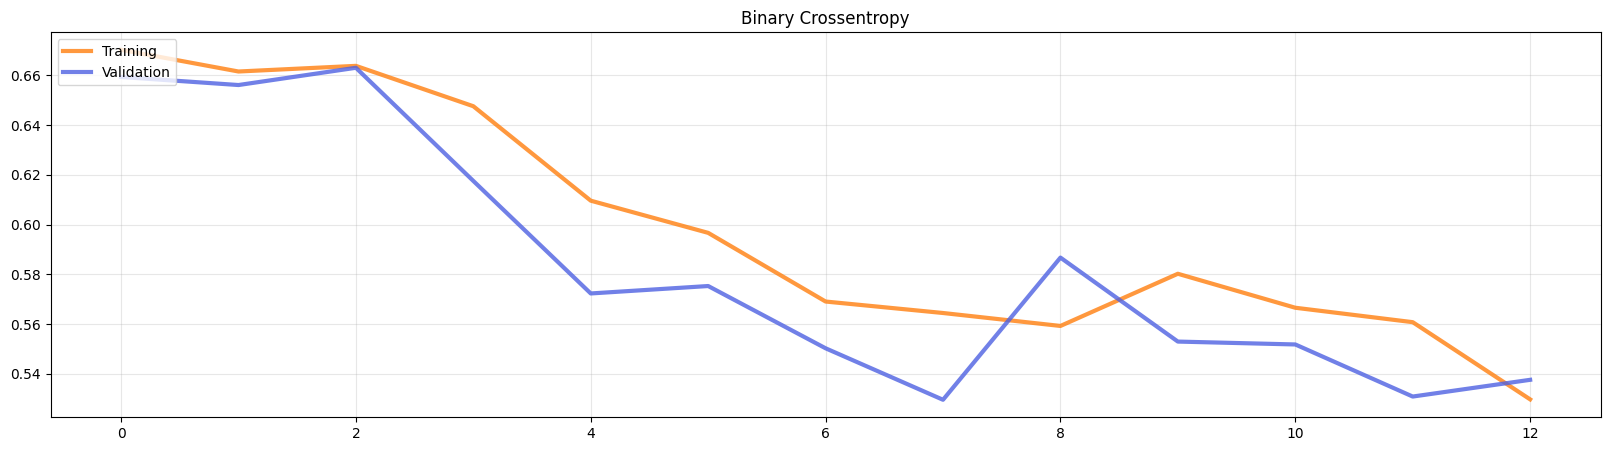

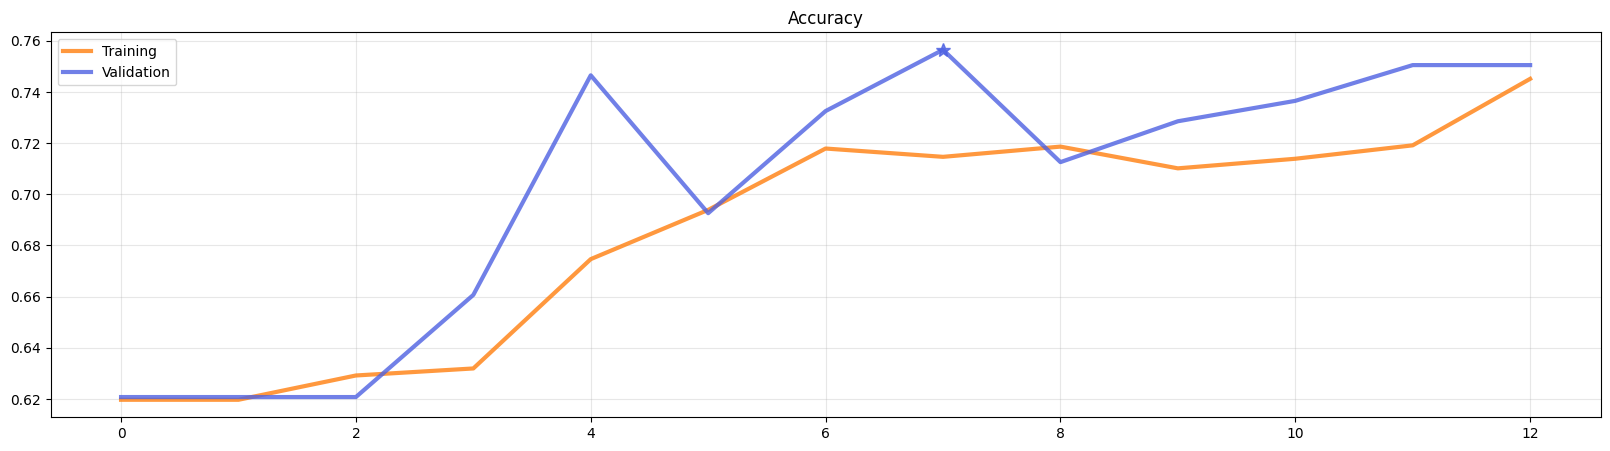

In [37]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

Input image
[[0.20695192]]


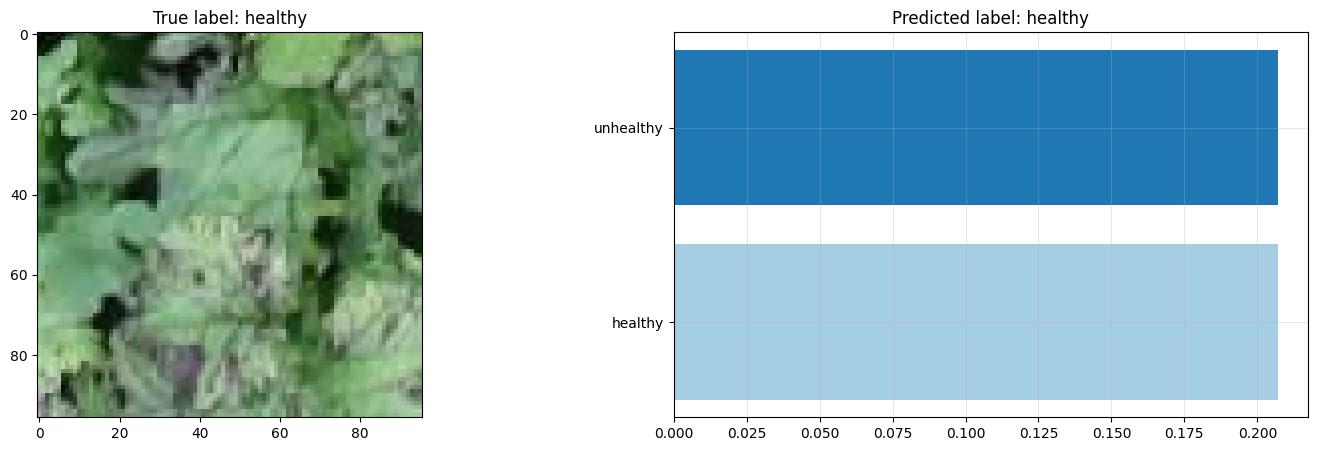

In [43]:

# Choose a random image for visualization
image_idx = np.random.randint(0, len(X_test))

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow(X_test[image_idx])
ax1.set_title('True label: ' + labels[y_test[image_idx]])
prediction = model.predict(np.expand_dims(X_test[image_idx], axis=0), verbose=0)
print(prediction)
ax2.barh(list(labels.values()), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

## Make Inference

In [88]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (501, 1)


Accuracy: 0.7066
Precision: 0.6945
Recall: 0.6584
F1: 0.6631


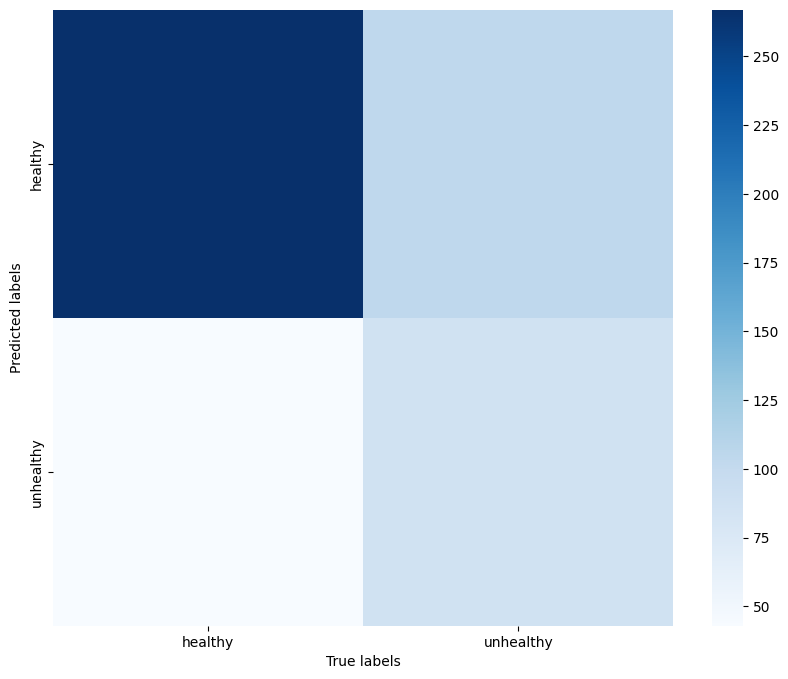

In [95]:

# Compute the confusion matrix
rounded_predictions = np.round(predictions.flatten()).astype(int)
cm = confusion_matrix(y_test, rounded_predictions)

# Compute classification metrics
accuracy = accuracy_score(y_test, rounded_predictions)
precision = precision_score(y_test, rounded_predictions, average='macro')
recall = recall_score(y_test, rounded_predictions, average='macro')
f1 = f1_score(y_test, rounded_predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()